Imports

In [6]:
from ultralytics import YOLO
import yaml, os, sys, glob, random
import torch
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())

PyTorch: 2.5.1+cu121 | CUDA available: True


Data Description

In [7]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, "dataset")
DATA_YAML = os.path.join(data_dir, "data.yaml")
assert os.path.exists(DATA_YAML), f"data.yaml not found at {DATA_YAML}"

with open(DATA_YAML, "r") as f:
    data_cfg = yaml.safe_load(f)

print("Classes:", data_cfg.get("names"))

Classes: ['fish']


In [8]:
# Collect a few images from the train split
names = data_cfg.get("names", [])
train_path = os.path.join(data_dir, "train//images")
img_exts = ("*.jpg")
train_imgs = []
for ext in img_exts:
    train_imgs.extend(glob.glob(os.path.join(train_path, ext)))
train_imgs.sort()

print(f"Found {len(train_imgs)} train images")
assert len(train_imgs) > 0, "No training images found. Check data.yaml paths."

Found 63 train images


Show some sample images

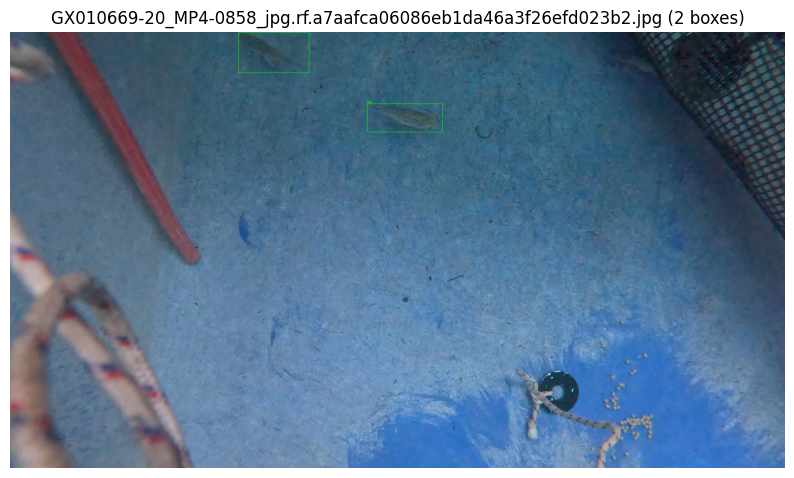

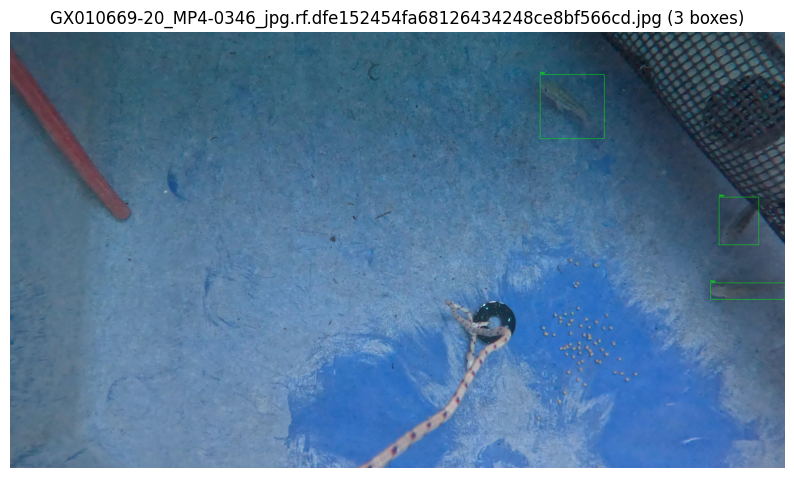

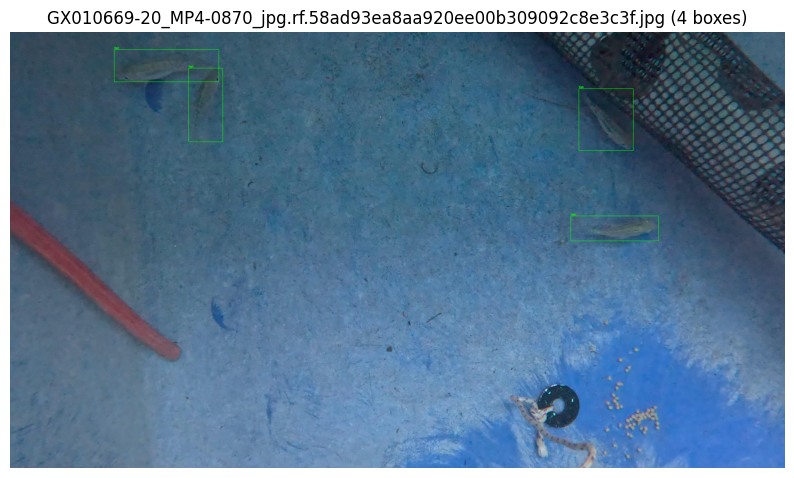

In [9]:
import os, cv2, random
import matplotlib.pyplot as plt

def img_to_label_path(img_path: str) -> str:
    """Map each image to its corresponding YOLO label file."""
    base, fname = os.path.split(img_path)
    root = os.path.dirname(base)

    # Prefer replacing 'images' with 'labels'
    if "images" in base:
        label_path = base.replace("images", "labels")
        candidate = os.path.join(label_path, os.path.splitext(fname)[0] + ".txt")
        if os.path.exists(candidate):
            return candidate

    # Fallbacks
    c1 = os.path.join(root, "labels", os.path.splitext(fname)[0] + ".txt")
    c2 = os.path.join(base, os.path.splitext(fname)[0] + ".txt")
    return c1 if os.path.exists(c1) else c2


def read_yolo_labels(txt_path):
    """Read YOLOv8 detection labels: cls x_center y_center width height (normalized)."""
    boxes = []
    if os.path.exists(txt_path):
        with open(txt_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls = int(float(parts[0]))
                    xc, yc, w, h = map(float, parts[1:5])
                    boxes.append([cls, xc, yc, w, h])
    return boxes


def yolo_to_xyxy(cls, xc, yc, w, h, W, H):
    """Convert normalized YOLO box to pixel coordinates."""
    x1 = int((xc - w / 2) * W)
    y1 = int((yc - h / 2) * H)
    x2 = int((xc + w / 2) * W)
    y2 = int((yc + h / 2) * H)
    return cls, x1, y1, x2, y2


def show_with_boxes(img_path):
    """Show image with YOLO bounding boxes."""
    img = cv2.imread(img_path)
    assert img is not None, f"Failed to read image: {img_path}"
    H, W = img.shape[:2]
    lbl = img_to_label_path(img_path)
    boxes = read_yolo_labels(lbl)

    vis = img.copy()
    for b in boxes:
        cls, x1, y1, x2, y2 = yolo_to_xyxy(b[0], b[1], b[2], b[3], b[4], W, H)
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cls_name = names[cls] if 0 <= cls < len(names) else str(cls)
        cv2.putText(vis, cls_name, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 7))
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{os.path.basename(img_path)} ({len(boxes)} boxes)")
    plt.show()


# --- Run visualization for a few random samples ---
sample_imgs = random.sample(train_imgs, min(3, len(train_imgs)))
for p in sample_imgs:
    show_with_boxes(p)


Train and log to wandb

In [10]:
from ultralytics import YOLO
import wandb, os

def wandb_callback(trainer):
    """
    Custom YOLO callback — runs every epoch.
    Logs all important metrics from the YOLO trainer object.
    """
    metrics = trainer.metrics or {}
    epoch = trainer.epoch + 1

    wandb.log({
        "epoch": epoch,
        "train/box_loss": metrics.get("train/box_loss"),
        "train/cls_loss": metrics.get("train/cls_loss"),
        "train/dfl_loss": metrics.get("train/dfl_loss"),
        "val/precision": metrics.get("metrics/precision(B)"),
        "val/recall": metrics.get("metrics/recall(B)"),
        "val/mAP50": metrics.get("metrics/mAP50(B)"),
        "val/mAP50-95": metrics.get("metrics/mAP50-95(B)"),
        "lr": trainer.lr,
    })

# --- login to your account ---
os.environ["WANDB_API_KEY"] = "68591fc7177da3394b90d1c3d2ef0183d85215ab"
wandb.login(key=os.environ["WANDB_API_KEY"])

# --- initialize your W&B run (optional, for custom naming) ---
wandb.init(project="fish_yolo_project", name="fish_yolo_exp1")

# --- train YOLOv8 ---
model = YOLO("yolov8s.pt")
model.add_callback("on_fit_epoch_end", wandb_callback)
results  = model.train(
    data=DATA_YAML,
    epochs=10,
    imgsz=640,
    batch=16,
    device=0
)

wandb.finish()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ndvam\_netrc


New https://pypi.org/project/ultralytics/8.3.218 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.217  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\ndvam\PycharmProjects\train_yolo_for_fish_detection\dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mos

epoch,▁▂▃▃▄▅▆▆▇██
val/mAP50,▁▁▇▇███████
val/mAP50-95,▁▁▆▆▇████▇█
val/precision,▁▁▇▇▇██████
val/recall,▁▃▆▇███████
epoch,10
val/mAP50,0.93523
val/mAP50-95,0.54876
val/precision,0.83352
val/recall,0.94681
